<div style="text-align:center">

# M508C
## Big Data Analytics (WS0925)
### *Individual Final Project*

<hr/>

<p style="text-align:center">
<strong>Student Name</strong>: Anh Tuan Ta<br/>
<strong>Student ID</strong>: GH1046139.<br/>
<strong>Student Email</strong>: anh.ta@gisma-student.com<br/>
<strong>LinkedIn</strong>:
<a href="https://www.linkedin.com/in/ta-anh-tuan-ai-engineer">https://www.linkedin.com/in/ta-anh-tuan-ai-engineer</a>
</p>

<p style="text-align:center">MSc of DATA SCIENCE, AI AND DIGITAL BUSINESS</p>

<hr/>


</div>

# Emotion Classification on Tweets using Natural Language Processing

## Problem Statement

### Background and Motivation
Social media platforms such as Twitter contain large volumes of short, informal text where users express emotions in response to personal experiences and real-world events. Automatically identifying emotions from these tweets is valuable for applications such as customer feedback analysis, brand monitoring, and public sentiment tracking.

However, tweet text poses several challenges for NLP systems:
- Tweets are short and noisy, often containing informal language.
- Emotional categories are unevenly distributed, leading to class imbalance.
- Some emotions (e.g. *love* and *surprise*) are harder to detect due to limited training examples and semantic overlap with other classes.

Manual analysis is infeasible at scale, motivating the use of supervised machine learning and deep learning techniques for emotion classification.

### Objective
The objective of this project is to **build and evaluate an end-to-end supervised NLP pipeline** that classifies tweets into one of **six emotion categories**:

**sadness, joy, love, anger, fear, surprise**

Given a raw tweet as input, the system predicts a single emotion label.

### Modeling Approach
To study the impact of different text representations and modeling paradigms, this project implements and compares **three models**, all trained and evaluated on the same dataset:

1. **TF-IDF + Logistic Regression**  
   A classical machine-learning baseline using bag-of-words features.

2. **Word2Vec + LSTM**  
   A sequence-based neural model using pre-trained Word2Vec embeddings combined with an LSTM network to capture sequential word dependencies.

3. **BERT Fine-Tuning**  
   A transformer-based model that leverages contextualized embeddings through fine-tuning of a pre-trained BERT model.

Each model follows a preprocessing and training strategy consistent with its architecture.

### Handling Class Imbalance
The dataset exhibits moderate class imbalance. To address this:
- **Random oversampling** is applied **only to the TF-IDF + Logistic Regression model**.
- **Class-weighted loss functions** are used for the **LSTM** and **BERT** models during training.

This ensures fair comparison while respecting the constraints of each modeling approach.

### Evaluation Strategy
All models are evaluated on a held-out test set using:
- **Accuracy**
- **Macro-averaged F1-score**
- **Weighted F1-score**
- **Per-class precision, recall, and F1-score**
- **Confusion matrices** for error analysis

Macro F1-score is emphasized to assess performance on minority emotion classes.

### Expected Outcome
The project aims to:
- Compare classical, neural, and transformer-based NLP models under the same task.
- Analyze how representation choice affects performance on short, imbalanced text data.
- Identify strengths and limitations of each approach for tweet-based emotion classification.

The results provide practical insights into model selection for real-world emotion analysis tasks.


# 1. Imports and Config

In [1]:
import os
import random
from collections import Counter

import numpy as np
import pandas as pd

import re
from itertools import chain
import emoji  

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import RandomOverSampler

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, regularizers

from transformers import TrainingArguments

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import torch
from torch.utils.data import Dataset

/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# NLTK downloads
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/taanhtuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taanhtuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/taanhtuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [5]:
EMOTION_DICT = {
    0: "sadness", 
    1: "joy", 
    2: "love", 
    3: "anger", 
    4: "fear", 
    5: "surprise"
}

# 2. Load Data

In [6]:
DATA_DIR = "data/Emotion6"

In [7]:
TRAIN_PATH = os.path.join(DATA_DIR, "training.csv")
DEV_PATH   = os.path.join(DATA_DIR, "validation.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

In [8]:
train_df = pd.read_csv(TRAIN_PATH)
dev_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)

In [9]:
print("Train shape:", train_df.shape)

Train shape: (16000, 2)


In [10]:
print("Dev shape  :", dev_df.shape)

Dev shape  : (2000, 2)


In [11]:
print("Test shape :", test_df.shape)

Test shape : (2000, 2)


In [12]:
display(train_df.head())

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
display(dev_df.head())

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [14]:
display(test_df.head())

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


# 3. Data Preprocessing + EDA

## 3.1 Text Cleaning + Encoding

### Remove empty text and label

In [15]:
train_df = train_df.dropna(subset=["text", "label"])
dev_df   = dev_df.dropna(subset=["text", "label"])
test_df  = test_df.dropna(subset=["text", "label"])

### Label Encoding

In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df["label"])

LabelEncoder()

In [17]:
train_df["label_id"] = label_encoder.transform(train_df["label"])
dev_df["label_id"]   = label_encoder.transform(dev_df["label"])
test_df["label_id"]  = label_encoder.transform(test_df["label"])

In [18]:
NUM_CLASSES = len(label_encoder.classes_)
NUM_CLASSES

6

In [19]:
print("Classes:", list(label_encoder.classes_))

Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


### Detect emojis & hashtags

In [20]:
def extract_emojis(text):
    text = str(text)
    return ''.join(ch for ch in text if ch in emoji.EMOJI_DATA)

def extract_hashtags(text):
    text = str(text)
    return re.findall(r'#\w+', text)

# add columns to train_df

train_df["emojis"] = train_df["text"].astype(str).apply(extract_emojis)
train_df["num_emojis"] = train_df["emojis"].str.len()

train_df["hashtags"] = train_df["text"].astype(str).apply(extract_hashtags)
train_df["num_hashtags"] = train_df["hashtags"].str.len()

In [21]:
print("Emoji / Hashtag Usage in Training Set")

print("Tweets with ≥1 emoji    :", (train_df["num_emojis"] > 0).mean() * 100, "%")
print("Tweets with ≥1 hashtag  :", (train_df["num_hashtags"] > 0).mean() * 100, "%")

print("\nAverage emojis per tweet  :", train_df["num_emojis"].mean())
print("Average hashtags per tweet:", train_df["num_hashtags"].mean())

Emoji / Hashtag Usage in Training Set
Tweets with ≥1 emoji    : 0.0 %
Tweets with ≥1 hashtag  : 0.0 %

Average emojis per tweet  : 0.0
Average hashtags per tweet: 0.0


### Quick Look: Emoji & Hashtag Presence

The dataset contains **no detectable emojis or hashtags**:

- **Tweets with ≥ 1 emoji:** 0.0%  
- **Tweets with ≥ 1 hashtag:** 0.0%  
- **Average emojis per tweet:** 0.0  
- **Average hashtags per tweet:** 0.0  

This confirms that emojis and hashtags **do not appear** in the dataset, so keeping/removing them **has no impact** on preprocessing or model performance.


### Create Raw + Cleaned Text Lists

In [22]:
def clean_tokens(text):
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

In [23]:
train_df["clean_tokens"] = train_df["text"].astype(str).apply(clean_tokens)
train_df["clean_text"] = train_df["clean_tokens"].apply(lambda x: " ".join(x))

In [24]:
print("Display few examples:")
for i in range(3):
    print(f"RAW   : {train_df.loc[i, 'text']}")
    print(f"CLEAN : {train_df.loc[i, 'clean_text']}")
    print("---")

Display few examples:
RAW   : i didnt feel humiliated
CLEAN : didnt feel humiliated
---
RAW   : i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
CLEAN : go feeling hopeless damned hopeful around someone care awake
---
RAW   : im grabbing a minute to post i feel greedy wrong
CLEAN : im grabbing minute post feel greedy wrong
---


In [25]:
dev_df["clean_tokens"] = dev_df["text"].astype(str).apply(clean_tokens)
dev_df["clean_text"] = dev_df["clean_tokens"].apply(lambda x: " ".join(x))

In [26]:
print("Display few examples:")
for i in range(3):
    print(f"RAW   : {dev_df.loc[i, 'text']}")
    print(f"CLEAN : {dev_df.loc[i, 'clean_text']}")
    print("---")

Display few examples:
RAW   : im feeling quite sad and sorry for myself but ill snap out of it soon
CLEAN : im feeling quite sad sorry ill snap soon
---
RAW   : i feel like i am still looking at a blank canvas blank pieces of paper
CLEAN : feel like still looking blank canvas blank piece paper
---
RAW   : i feel like a faithful servant
CLEAN : feel like faithful servant
---


In [27]:
test_df["clean_tokens"] = test_df["text"].astype(str).apply(clean_tokens)
test_df["clean_text"] = test_df["clean_tokens"].apply(lambda x: " ".join(x))

In [28]:
print("Display few examples:")
for i in range(3):
    print(f"RAW   : {test_df.loc[i, 'text']}")
    print(f"CLEAN : {test_df.loc[i, 'clean_text']}")
    print("---")

Display few examples:
RAW   : im feeling rather rotten so im not very ambitious right now
CLEAN : im feeling rather rotten im ambitious right
---
RAW   : im updating my blog because i feel shitty
CLEAN : im updating blog feel shitty
---
RAW   : i never make her separate from me because i don t ever want her to feel like i m ashamed with her
CLEAN : never make separate ever want feel like ashamed
---


## 3.2 Exploratory Data Analysis (EDA)

### Percentages of each label

In [29]:
for lbl, count in train_df["label"].value_counts().items():
    pct = count / len(train_df) * 100
    print(f"Label {lbl}: {count:,} samples ({pct:.2f}%)")

Label 1: 5,362 samples (33.51%)
Label 0: 4,666 samples (29.16%)
Label 3: 2,159 samples (13.49%)
Label 4: 1,937 samples (12.11%)
Label 2: 1,304 samples (8.15%)
Label 5: 572 samples (3.57%)


### Label Distribution Visualization

/var/folders/6x/h489kd6s4lxbdnxrhw8mvt140000gn/T/ipykernel_55043/988442562.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([EMOTION_DICT[i] for i in order_labels])


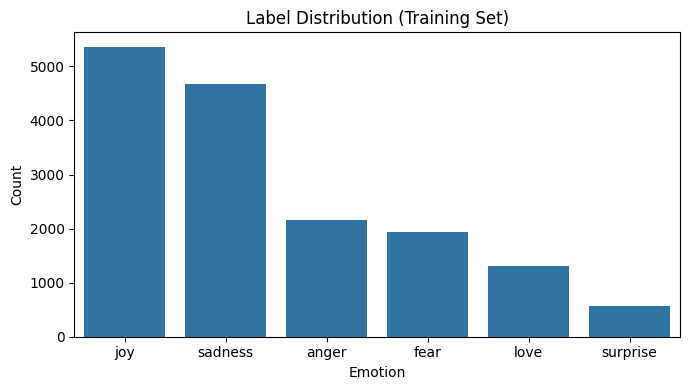

In [30]:
# Order by frequency of numeric labels
order_labels = train_df["label"].value_counts().index

plt.figure(figsize=(7,4))
ax = sns.countplot(
    x="label",
    data=train_df,
    order=order_labels
)

# Replace tick labels (0..5) with emotion names
ax.set_xticklabels([EMOTION_DICT[i] for i in order_labels])

plt.title("Label Distribution (Training Set)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Interpretation

The training dataset shows a clear **class imbalance**:

- **Joy (label 1)** and **Sadness (label 0)** are the most common classes.
- **Anger (3)** and **Fear (4)** appear moderately often.
- **Love (2)** and especially **Surprise (5)** are **minority classes**.

This imbalance is important because it can lead to:

- Lower recall and F1-scores for rare classes (e.g., *love*, *surprise*)
- Bias toward predicting majority classes
- Unstable training for neural models

To address this, the pipeline applies **oversampling** and **class weighting**, ensuring that all models treat minority emotions more fairly during training.

### Average Tweet Length (in words) per Emotion

In [31]:
# Add num_words feature
for df_part in (train_df, dev_df, test_df):
    df_part["num_words"] = df_part["text"].astype(str).apply(lambda x: len(x.split()))

In [32]:
# Compute average length per label
avg_len = (
    train_df
    .groupby("label")["num_words"]
    .mean()
    .reset_index()
    .rename(columns={"num_words": "avg_num_words"})
)

In [33]:
# Map numeric label -> emotion name
avg_len["emotion"] = avg_len["label"].map(EMOTION_DICT)

# Sort by average length (optional)
avg_len = avg_len.sort_values("avg_num_words", ascending=False)

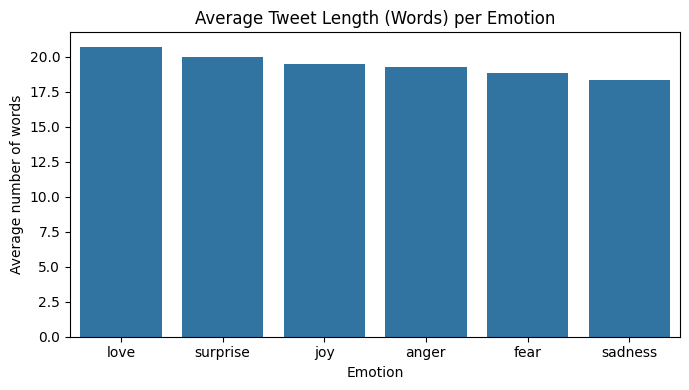

In [34]:
plt.figure(figsize=(7, 4))
sns.barplot(data=avg_len, x="emotion", y="avg_num_words")
plt.title("Average Tweet Length (Words) per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Average number of words")
plt.tight_layout()
plt.show()

## Quick Look – Average Tweet Length per Emotion

- **Love** tweets are the longest (~21 words), often containing more detailed emotional expression.  
- **Surprise** and **Joy** follow (~19–20 words), usually describing events or reactions.  
- **Anger** and **Fear** are slightly shorter (~19 words), often more direct.  
- **Sadness** tweets are the shortest (~18 words), typically brief statements of feeling.

Overall, all emotions fall within a **tight range (18–21 words)**, confirming that tweets are consistently short and supporting a moderate max sequence length (e.g., 40–50 tokens) for modeling.


### Tweet Length Distribution Visualization

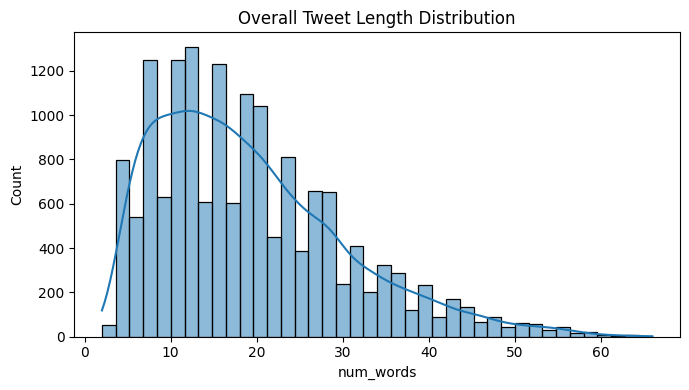

In [35]:
# Overall Tweet Length Distribution
plt.figure(figsize=(7,4))
sns.histplot(train_df["num_words"], bins=40, kde=True)
plt.title("Overall Tweet Length Distribution")
plt.xlabel("num_words")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

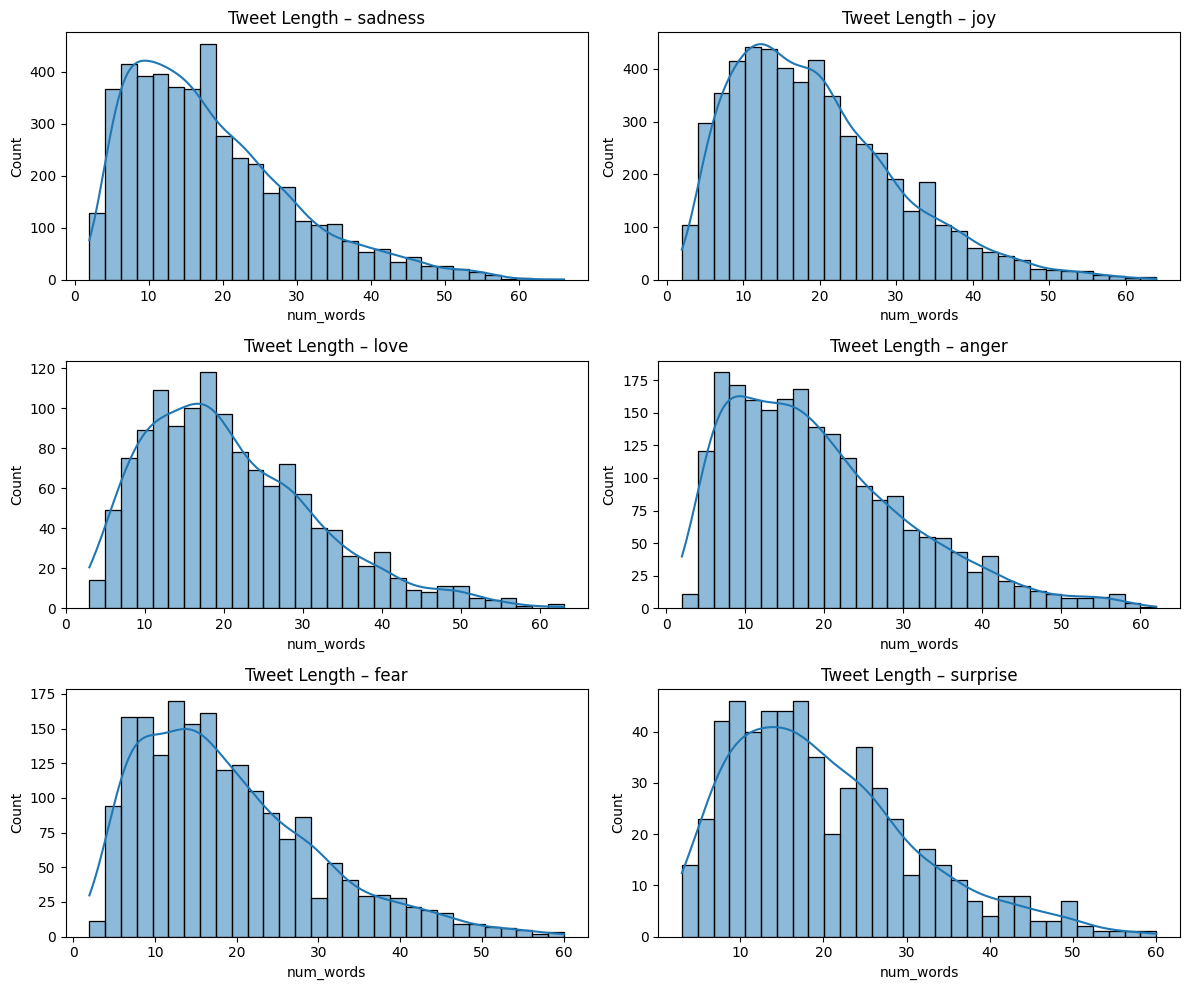

In [36]:
# Tweet Length Distribution per Emotion Label
plt.figure(figsize=(12, 10))

for i, (lbl, emotion_name) in enumerate(EMOTION_DICT.items(), 1):
    subset = train_df[train_df["label"] == lbl]["num_words"]

    plt.subplot(3, 2, i)
    sns.histplot(subset, bins=30, kde=True)
    plt.title(f"Tweet Length – {emotion_name}")
    plt.xlabel("num_words")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

### Quick Look — Word Length Analysis

#### Overall Interpretation
The dataset is dominated by **short tweets**, mostly between **8–20 words**, with a right-skewed tail up to ~60 words.  
This means:
- Most emotional content is expressed **briefly**.
- **Very long tweets are rare**, so models don’t need large max sequence lengths.
- Setting sequence length around **40–60 tokens** captures almost all samples.
- Short text makes TF-IDF, LSTM, and BERT all efficient to train.

Overall, emotion classification on this dataset is lightweight and well-bounded in length.

---
#### Quick Look — Per Emotion Label

- **Sadness:**: Slightly longer tweets; often **10–25 words** with reflective explanations.
- **Joy:**: Mostly short and spontaneous; concentrated around **8–18 words**.
- **Love:** More varied; many tweets between **12–25 words**, sometimes descriptive.
- **Anger:** Compact but with added context; common range **10–22 words**.
- **Fear:** Wider length spread; typically **10–25 words**, some longer descriptions.
- **Surprise:** Usually short reaction messages; often **8–16 words**.
---

### Top Words per Emotion Class

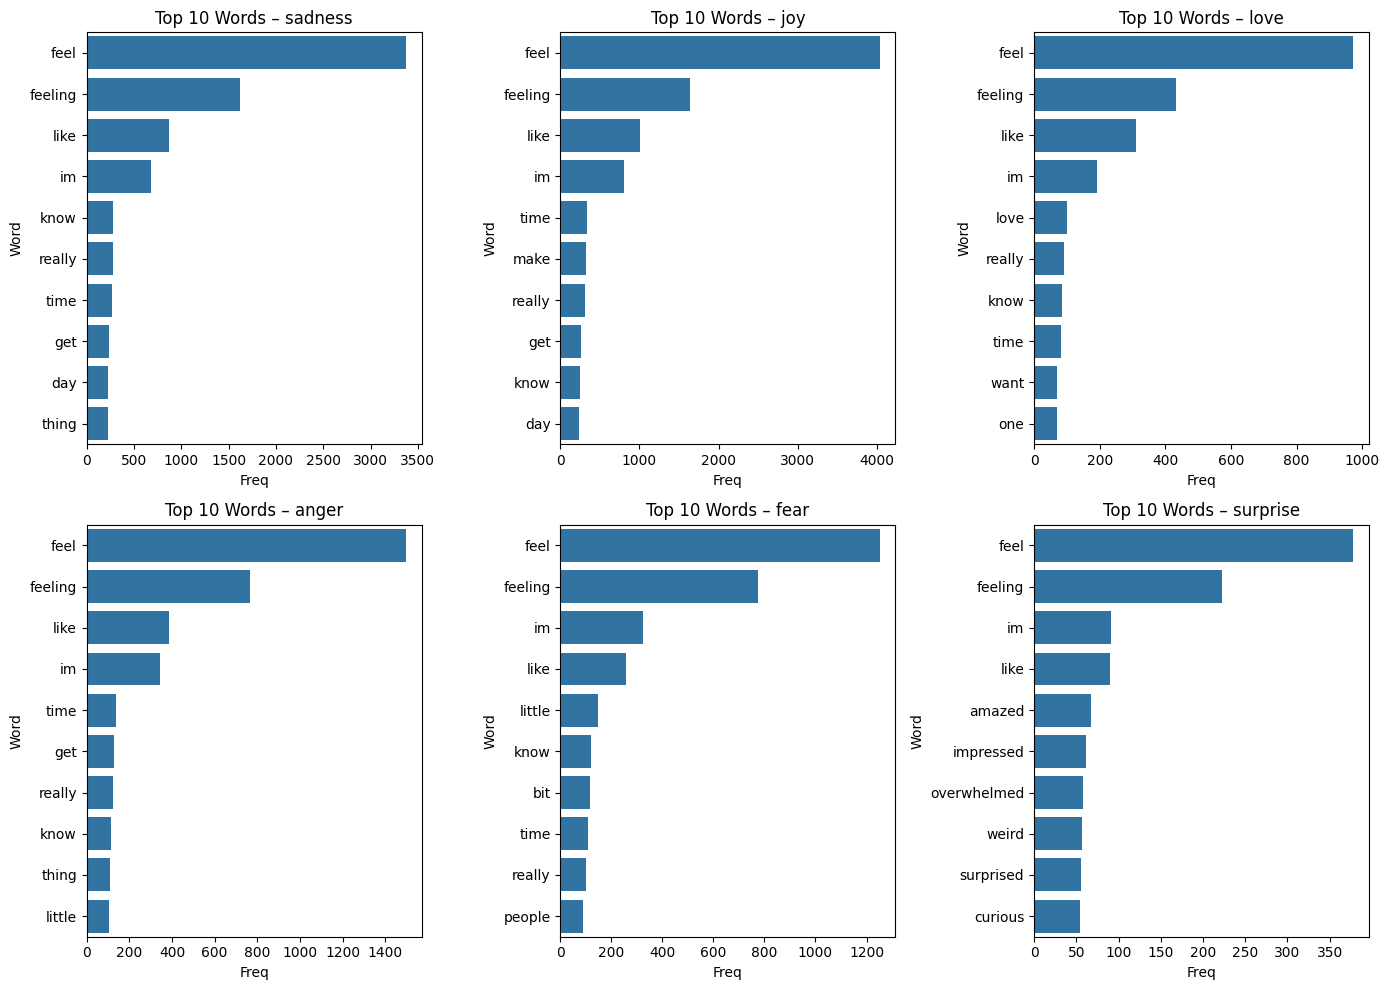

In [37]:
top_n = 10

plt.figure(figsize=(14, 10))

for i, (lbl, emotion_name) in enumerate(EMOTION_DICT.items(), 1):
    # Get cleaned tokens for this label
    subset = train_df[train_df["label"] == lbl]["clean_tokens"]

    # Flatten all token lists into one list
    tokens = []
    for tok_list in subset:
        tokens.extend(tok_list)

    # Top-N most common words
    counts = Counter(tokens).most_common(top_n)
    words  = [w for w, _ in counts]
    freqs  = [c for _, c in counts]

    # Plot
    plt.subplot(2, 3, i)
    sns.barplot(x=freqs, y=words, orient="h")
    plt.title(f"Top {top_n} Words – {emotion_name}")
    plt.xlabel("Freq")
    plt.ylabel("Word")

plt.tight_layout()
plt.show()

### Quick Insights: Top 10 Words per Emotion

- **Sadness:** dominated by *feel, feeling, like, im, know* → reflective, low-energy expressions.  
- **Joy:** similar structure but more positive verbs (*make, really*) → upbeat emotional tone.  
- **Love:** includes more relational words (*love, want, one*) → affectionate, connection-focused.  
- **Anger:** still uses *feel/feeling* but context is harsher → frustration, irritation.  
- **Fear:** shows uncertainty (*little, bit, people*) → hesitation, vulnerability.  
- **Surprise:** most distinct vocabulary (*amazed, impressed, overwhelmed*) → unexpected events, curiosity.

**Overall:** Many classes share core verbs like *feel/feeling*, but emotion-specific words help differentiate categories.

### WordClouds

In [38]:
def plot_wordcloud(texts, title):
    text = " ".join(texts)
    wc = WordCloud(width=900, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

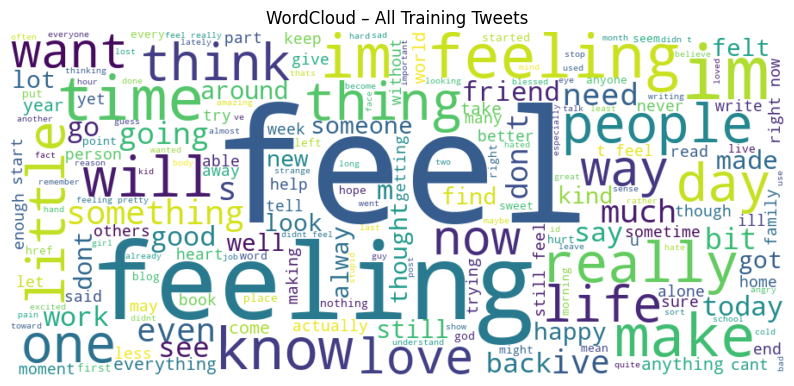

In [39]:
# Overall
plot_wordcloud(train_df["text"].tolist(), "WordCloud – All Training Tweets")

### Interpretation

The overall word cloud highlights the most frequent terms across all tweets. Words like **feel**, **im**, **make**, **time**, **love**, and **know** dominate, reflecting the emotional and personal nature of Twitter content. These frequent terms provide an initial sense of common themes before emotion-specific analysis.

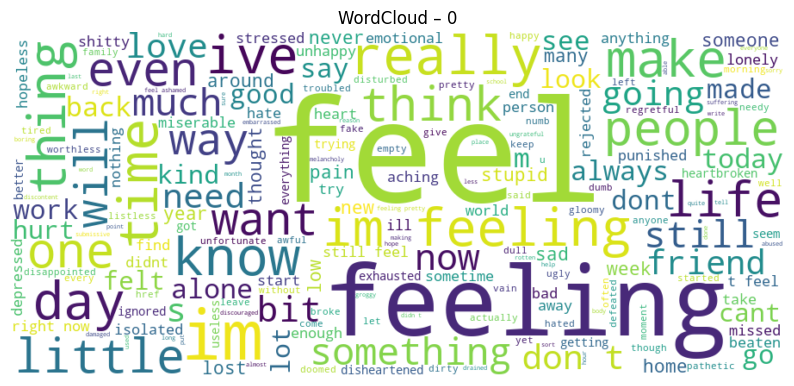

In [40]:
# sadness class
lbl = 0
lbl_name = EMOTION_DICT[lbl]

subset = train_df[train_df["label"] == lbl]
plot_wordcloud(subset["text"].tolist(), f"WordCloud – {lbl}")

### Interpretation (Sadness)

The sadness class is dominated by words expressing negative emotions and personal struggle. Terms like **feel**, **alone**, **hurt**, **pain**, **lost**, and **sad** appear frequently, reflecting themes of emotional distress, loneliness, and difficult life situations.


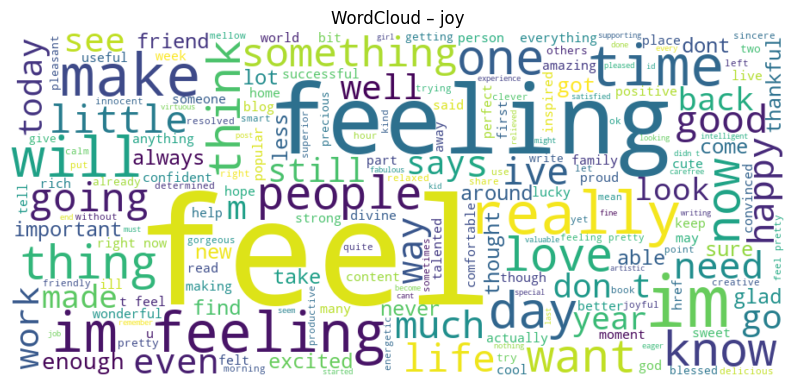

In [41]:
# joy class
lbl = 1
lbl_name = EMOTION_DICT[lbl]

subset = train_df[train_df["label"] == lbl]
plot_wordcloud(subset["text"].tolist(), f"WordCloud – {lbl_name}")

### Interpretation (Joy)

The joy class contains many positive and uplifting terms. Words such as **happy**, **good**, **love**, **excited**, **thankful**, and **glad** frequently appear, reflecting themes of celebration, appreciation, and positive life events.

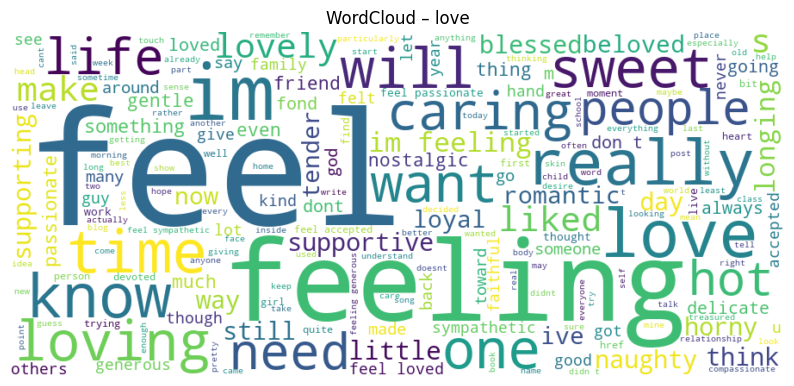

In [42]:
# love class
lbl = 2
lbl_name = EMOTION_DICT[lbl]

subset = train_df[train_df["label"] == lbl]
plot_wordcloud(subset["text"].tolist(), f"WordCloud – {lbl_name}")

### Interpretation (Love)

The love class features warm and affectionate words such as **love**, **lovely**, **caring**, **sweet**, **beloved**, and **romantic**. The vocabulary reflects themes of affection, connection, tenderness, and positive emotional bonding.


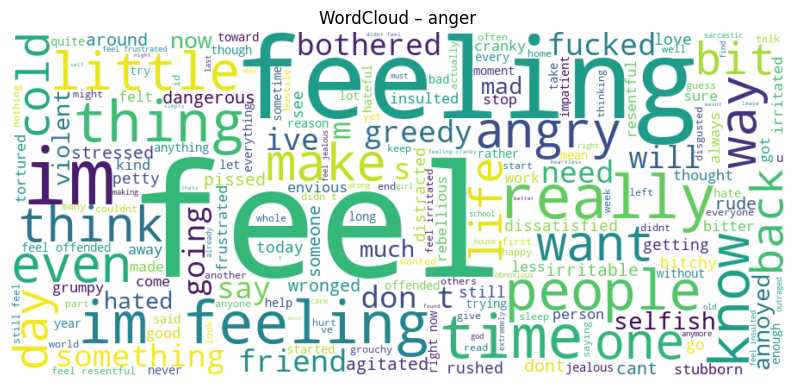

In [43]:
# anger class
lbl = 3
lbl_name = EMOTION_DICT[lbl]

subset = train_df[train_df["label"] == lbl]
plot_wordcloud(subset["text"].tolist(), f"WordCloud – {lbl_name}")

### Interpretation (Anger)

The anger class contains many negative and intense terms such as **angry**, **annoyed**, **pissed**, **frustrated**, **irritated**, and **bitter**. The vocabulary reflects themes of conflict, frustration, and emotional tension.

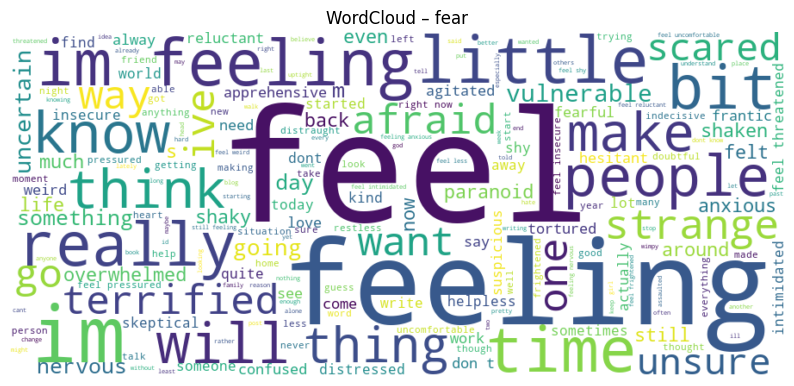

In [44]:
# fear class
lbl = 4
lbl_name = EMOTION_DICT[lbl]

subset = train_df[train_df["label"] == lbl]
plot_wordcloud(subset["text"].tolist(), f"WordCloud – {lbl_name}")

### Interpretation (Fear)

The fear class is dominated by words such as **afraid**, **scared**, **terrified**, **unsure**, **nervous**, and **anxious**, indicating strong feelings of uncertainty, vulnerability, and emotional distress. Many terms reflect panic, insecurity, and a sense of being overwhelmed.

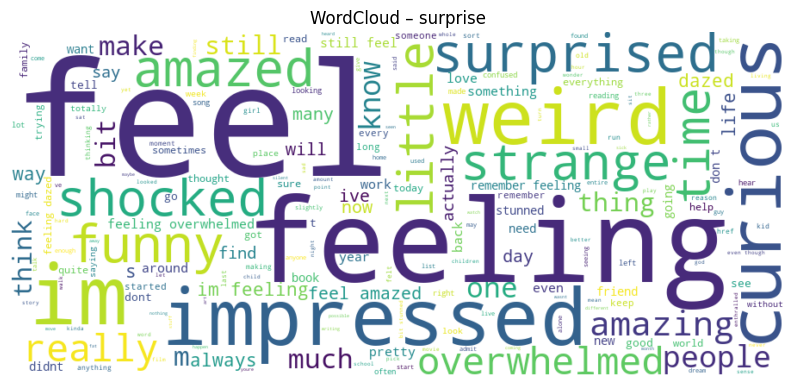

In [45]:
# surprise class
lbl = 5
lbl_name = EMOTION_DICT[lbl]

subset = train_df[train_df["label"] == lbl]
plot_wordcloud(subset["text"].tolist(), f"WordCloud – {lbl_name}")

### Interpretation (Surprise)

The surprise class includes words such as **amazed**, **shocked**, **curious**, **weird**, **impressed**, and **overwhelmed**, reflecting reactions to unexpected events. The language shows a mix of astonishment, curiosity, and positive surprise.

## 3.3 Preparing Clean Text and Labels for Modeling

In [46]:
# BERT uses raw text 
X_train_raw = train_df["text"].astype(str).tolist()
X_dev_raw   = dev_df["text"].astype(str).tolist()
X_test_raw  = test_df["text"].astype(str).tolist()

In [47]:
# Cleaned text lists
X_train_clean = train_df["clean_text"].tolist()
X_dev_clean   = dev_df["clean_text"].tolist()
X_test_clean  = test_df["clean_text"].tolist()

In [48]:
y_train = train_df["label_id"].values
y_dev   = dev_df["label_id"].values
y_test  = test_df["label_id"].values

## 3.4 Oversampling

Random oversampling is applied **only to the TF-IDF + Logistic Regression model** to mitigate class imbalance in the feature space. For neural models (Word2Vec + LSTM and BERT), oversampling is not used; instead, **class-weighted loss functions** are applied during training to address label imbalance.

In [49]:
print("Original label counts:", Counter(y_train))

Original label counts: Counter({np.int64(1): 5362, np.int64(0): 4666, np.int64(3): 2159, np.int64(4): 1937, np.int64(2): 1304, np.int64(5): 572})


In [50]:
ros = RandomOverSampler(random_state=SEED)
idx_dummy = np.arange(len(X_train_clean)).reshape(-1,1)
idx_res, y_res = ros.fit_resample(idx_dummy, y_train)
X_train_clean_bal = [X_train_clean[i[0]] for i in idx_res]
y_train_bal = y_res

In [51]:
print("Oversampled label counts:", Counter(y_train_bal))

Oversampled label counts: Counter({np.int64(0): 5362, np.int64(3): 5362, np.int64(2): 5362, np.int64(5): 5362, np.int64(4): 5362, np.int64(1): 5362})


# 4. Model Training

## 4.1 TF-IDF + Logistic Regression

In [52]:
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
    )),
])

In [53]:
tfidf_lr.fit(X_train_clean_bal, y_train_bal)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [54]:
y_pred_lr = tfidf_lr.predict(X_test_clean)

In [55]:
print("Result in TF-IDF + Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Macro F1:", f1_score(y_test, y_pred_lr, average="macro"))
print("Weighted F1:", f1_score(y_test, y_pred_lr, average="weighted"))

Result in TF-IDF + Logistic Regression:
Accuracy: 0.8955
Macro F1: 0.8512673279207412
Weighted F1: 0.8964496130401985


In [56]:
print("\nClassification Report:\n")
print(
    classification_report(
        y_test,
        y_pred_lr,
        target_names=EMOTION_DICT.values()
    )
)


Classification Report:

              precision    recall  f1-score   support

     sadness       0.95      0.92      0.93       581
         joy       0.93      0.91      0.92       695
        love       0.74      0.84      0.79       159
       anger       0.89      0.92      0.90       275
        fear       0.89      0.83      0.86       224
    surprise       0.68      0.74      0.71        66

    accuracy                           0.90      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000



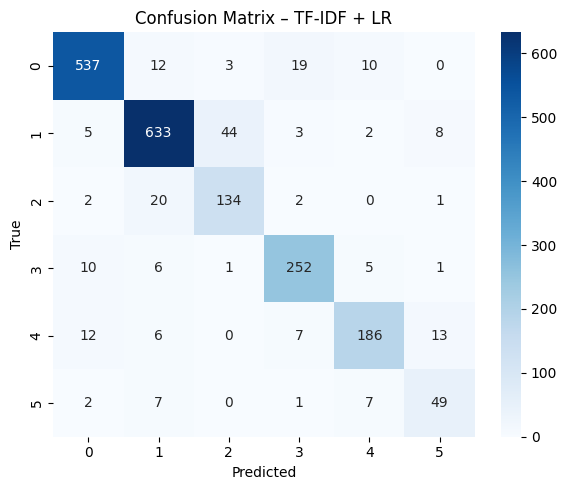

In [57]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – TF-IDF + LR")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Performance Summary — TF-IDF + Logistic Regression

- **Overall performance:**  
  - Accuracy: **0.90**  
  - Macro F1: **0.85**  
  - Weighted F1: **0.90**  
  Demonstrates a strong and stable baseline, especially considering class imbalance.

- **Strong classes:**  
  - *Sadness* and *Joy* achieve high precision and recall (F1 ≈ 0.92–0.93), reflecting clear lexical patterns captured well by TF-IDF.
  - *Anger* also performs robustly with balanced precision–recall.

- **Moderate classes:**  
  - *Fear* shows good overall performance but slightly lower recall, indicating occasional confusion with related emotions.
  - *Love* has decent recall but lower precision, suggesting overlap with *joy* and other positive expressions.

- **Challenging class:**  
  - *Surprise* remains the weakest (F1 ≈ 0.71), mainly due to limited samples and sparse, less distinctive vocabulary.

- **Error patterns (from confusion matrix):**  
  - Misclassifications mostly occur between semantically similar emotions (e.g., *joy ↔ love*, *fear ↔ anger*).
  - The model does not collapse to majority classes, indicating effective class weighting and balanced learning.

- **Overall takeaway:**  
  TF-IDF + Logistic Regression provides a **strong, efficient baseline** for tweet emotion classification, excelling on frequent emotions but limited in capturing deeper semantic nuances required for minority and subtle classes.

# 4.2 LSTM model

### Word2Vec + tokenizer

In [58]:
train_tokens = train_df["clean_tokens"].tolist()
dev_tokens   = dev_df["clean_tokens"].tolist()
test_tokens  = test_df["clean_tokens"].tolist()

all_tokens = train_tokens + dev_tokens + test_tokens

In [59]:
w2v = Word2Vec(
    sentences=all_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

print("Word2Vec vocab size:", len(w2v.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Word2Vec vocab size: 7537


In [60]:
# Keras tokenizer
MAX_WORDS = 20000
MAX_SEQ_LEN = 40

In [61]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts([" ".join(t) for t in all_tokens])

In [62]:
def to_seq(token_list):
    text = " ".join(token_list)
    seq = tokenizer.texts_to_sequences([text])[0]
    return seq

In [63]:
# Pad all sequences
def pad_all(tokens_list):
    seqs = tokenizer.texts_to_sequences([" ".join(t) for t in tokens_list])
    return pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

In [64]:
X_train_seq = pad_all(train_tokens)
X_dev_seq   = pad_all(dev_tokens)
X_test_seq  = pad_all(test_tokens)

In [65]:
EMB_DIM = 100

In [66]:
# Build embedding matrix
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
embedding_matrix = np.random.normal(0, 0.01, (vocab_size, EMB_DIM))

for w, i in tokenizer.word_index.items():
    if i < vocab_size and w in w2v.wv:
        embedding_matrix[i] = w2v.wv[w]

### LSTM model Training

In [67]:
tf.keras.backend.clear_session()

# Build model (Word2Vec embeddings)
lstm = tf.keras.Sequential([
    layers.Input(shape=(MAX_SEQ_LEN,)),
    layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],   # = EMB_DIM
        weights=[embedding_matrix],
        trainable=False,                        # Phase 1: freeze
        name="w2v_embedding"
    ),
    layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

In [68]:
# Compute class weights to handle label imbalance during training.
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}

In [69]:
callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=8,          
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
]

### Why two-phase training (Freeze → Unfreeze) for Word2Vec + LSTM?

Word2Vec embeddings provide a strong pretrained initialization, but they are trained on a general corpus and may not fully match the language style of tweets (slang, informal phrasing, short context). If the embeddings are fine-tuned from the start, training can become unstable and overfit quickly, especially under class imbalance.

To address this, the training is done in two phases:
- **Phase 1 (freeze embeddings):** keeps pretrained Word2Vec vectors fixed to provide a stable semantic foundation while the LSTM and classifier layers learn the task-specific decision boundaries.
- **Phase 2 (unfreeze embeddings):** enables fine-tuning with a smaller learning rate, allowing the embeddings to adapt to the emotion classification domain without destroying the pretrained structure.

This approach improves training stability and often yields better generalization than fully freezing embeddings or fine-tuning them aggressively from the beginning.


#### Phase 1: train with frozen embeddings (stable start)

In [70]:
FROZEN_LSTM_EPOCH = 5

In [71]:
lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("PHASE 1: Frozen Word2Vec embeddings")
hist1 = lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_dev_seq, y_dev),
    epochs=FROZEN_LSTM_EPOCH,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

PHASE 1: Frozen Word2Vec embeddings
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.1804 - loss: 1.7996 - val_accuracy: 0.0420 - val_loss: 1.7938 - learning_rate: 0.0010
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.1796 - loss: 1.7971 - val_accuracy: 0.0885 - val_loss: 1.7962 - learning_rate: 0.0010
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.2004 - loss: 1.7952 - val_accuracy: 0.1375 - val_loss: 1.7968 - learning_rate: 0.0010
Epoch 4/5
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2102 - loss: 1.7799
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.1984 - loss: 1.7941 - val_accuracy: 0.1375 - val_loss: 1.7974 - learning_rate: 0.0010
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.1372 - loss: 1.7933 - val_accuracy: 0.0930 - val_loss: 1.7944 - learning_rate: 5.0000e-04
Restoring model weights from the end of the bes

#### Phase 2: unfreeze embeddings and fine-tune (adapt to task/domain)

In [72]:
LSTM_EPOCH = 150

In [73]:
lstm.get_layer("w2v_embedding").trainable = True

lstm.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nPHASE 2: Unfrozen Word2Vec embeddings (fine-tuning)")
hist2 = lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_dev_seq, y_dev),
    epochs=LSTM_EPOCH,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


PHASE 2: Unfrozen Word2Vec embeddings (fine-tuning)
Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2477 - loss: 1.7971 - val_accuracy: 0.3520 - val_loss: 1.7939 - learning_rate: 2.0000e-04
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.1949 - loss: 1.7963 - val_accuracy: 0.2790 - val_loss: 1.7949 - learning_rate: 2.0000e-04
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2199 - loss: 1.7384 - val_accuracy: 0.2040 - val_loss: 1.5043 - learning_rate: 2.0000e-04
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3189 - loss: 1.4857 - val_accuracy: 0.2410 - val_loss: 1.2564 - learning_rate: 2.0000e-04
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3407 - loss: 1.3626 - val_accuracy: 0.2460 - val_loss: 1.2158 - learning_rate: 2.0000e-04
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3385 - loss: 1.2820 - val_accuracy: 0.2700 - val_loss: 1.1842 - learning_rate: 2.00

In [74]:
y_pred_lstm = np.argmax(lstm.predict(X_test_seq), axis=1)

print("Results in Word2Vec + LSTM:")
print("Accuracy :", accuracy_score(y_test, y_pred_lstm))
print("Macro F1 :", f1_score(y_test, y_pred_lstm, average="macro"))
print("Weighted :", f1_score(y_test, y_pred_lstm, average="weighted"))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Results in Word2Vec + LSTM:
Accuracy : 0.884
Macro F1 : 0.8402721789871612
Weighted : 0.8863248305735015


In [75]:
# Merge Phase 1 + Phase 2 history into one object-like dict
history = {}
for k in hist1.history.keys():
    history[k] = hist1.history[k] + hist2.history.get(k, [])

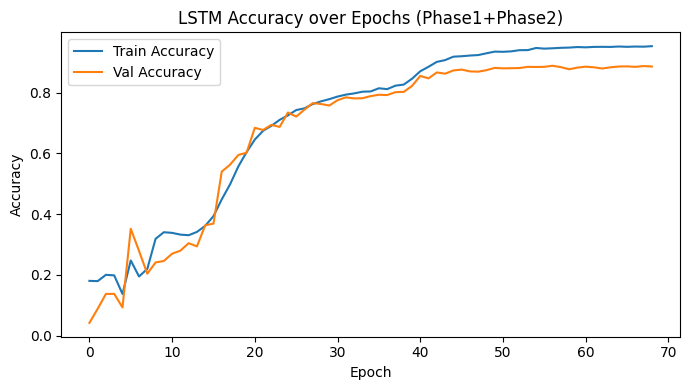

In [76]:
plt.figure(figsize=(7,4))
plt.plot(history["accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Val Accuracy")
plt.title("LSTM Accuracy over Epochs (Phase1+Phase2)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Quick Look — LSTM Accuracy over Epochs (Phase 1 + Phase 2)

- **Consistent learning:** Training and validation accuracy rise smoothly, indicating stable optimization across both phases.
- **Convergence:** Validation accuracy plateaus around **~0.87–0.88** after ~40 epochs.
- **Generalization gap:** Training accuracy continues to improve slightly while validation stays flat → **mild overfitting**, but well-controlled.
- **Practical takeaway:** Best model performance is reached near the plateau; further training yields minimal validation gains.


In [77]:
print("\nClassification Report:\n")
print(
    classification_report(
    y_test,
    y_pred_lstm,
    target_names=EMOTION_DICT.values()
))



Classification Report:

              precision    recall  f1-score   support

     sadness       0.96      0.91      0.93       581
         joy       0.94      0.88      0.91       695
        love       0.73      0.91      0.81       159
       anger       0.86      0.88      0.87       275
        fear       0.80      0.83      0.81       224
    surprise       0.63      0.79      0.70        66

    accuracy                           0.88      2000
   macro avg       0.82      0.87      0.84      2000
weighted avg       0.89      0.88      0.89      2000



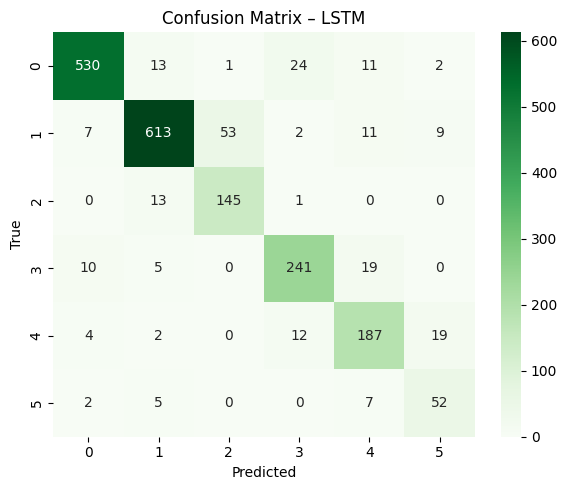

In [78]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_lstm, annot=True, fmt="d", cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix – LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Performance Summary — LSTM (Word2Vec + LSTM)

- **Overall performance:**  
  - Accuracy: **0.88**  
  - Macro F1: **0.84**  
  - Weighted F1: **0.89**  
  Indicates good overall performance with reasonable handling of class imbalance.

- **Strong classes:**  
  - *Sadness* and *Joy* achieve high precision and F1 (>0.90), showing the model learns dominant emotions well.
  - *Anger* and *Fear* are also classified reliably with balanced precision–recall.

- **Weaker classes:**  
  - *Love* shows high recall but lower precision, suggesting confusion with semantically similar emotions.
  - *Surprise* remains the hardest class (lowest F1 ≈ 0.70), largely due to limited samples and overlap with other emotions.

- **Error patterns (from confusion matrix):**  
  - Most misclassifications occur between emotionally close classes (e.g., *joy ↔ love*, *fear ↔ anger*).
  - Diagonal dominance confirms stable learning, with no collapse to majority classes.

- **Overall takeaway:**  
  The LSTM with Word2Vec embeddings provides **solid, balanced performance**, capturing sequential information better than simple bag-of-words models, but still struggles with minority and semantically subtle emotion classes.

## 4.3 BERT dataset

### BERT dataset

In [79]:
BERT_MODEL = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

In [80]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.texts)

train_dataset = EmotionDataset(X_train_raw, y_train, bert_tokenizer)
dev_dataset   = EmotionDataset(X_dev_raw, y_dev, bert_tokenizer)
test_dataset  = EmotionDataset(X_test_raw, y_test, bert_tokenizer)

### Fine-tuning BERT

In [81]:
BERT_EPOCH=5

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

bert_model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=NUM_CLASSES
).to(device)

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

In [84]:
args = TrainingArguments(
    output_dir="./bert_out",
    num_train_epochs=BERT_EPOCH,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_steps=50,
)

In [85]:
trainer = Trainer(
    model=bert_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.638900
100,1.218600
150,0.947500
200,0.714100
250,0.553000
300,0.424200
350,0.397200
400,0.366800
450,0.280600
500,0.297300


/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=5000, training_loss=0.16934441967010497, metrics={'train_runtime': 2665.9758, 'train_samples_per_second': 30.008, 'train_steps_per_second': 1.875, 'total_flos': 2631205048320000.0, 'train_loss': 0.16934441967010497, 'epoch': 5.0})

In [86]:
outputs = trainer.predict(test_dataset)
y_pred_bert = np.argmax(outputs.predictions, axis=1)

/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [87]:
outputs = trainer.predict(test_dataset)
y_pred_bert = np.argmax(outputs.predictions, axis=1)

print("BERT Fine-Tuning")
print("Accuracy :", accuracy_score(y_test, y_pred_bert))
print("Macro F1 :", f1_score(y_test, y_pred_bert, average="macro"))
print("Weighted :", f1_score(y_test, y_pred_bert, average="weighted"))

/Users/taanhtuan/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT Fine-Tuning
Accuracy : 0.9195
Macro F1 : 0.8680832604064883
Weighted : 0.9196056838807994


In [88]:
print(
    classification_report(
        y_test,
        y_pred_bert,
        target_names=EMOTION_DICT.values()
    )
)

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.94      0.94       695
        love       0.81      0.81      0.81       159
       anger       0.93      0.91      0.92       275
        fear       0.86      0.90      0.88       224
    surprise       0.70      0.70      0.70        66

    accuracy                           0.92      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



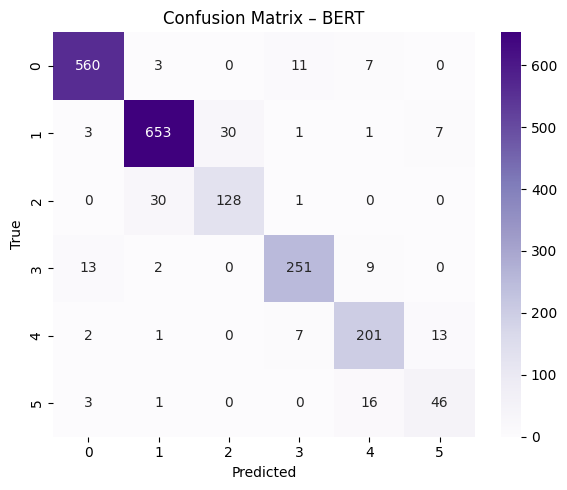

In [89]:
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_bert, annot=True, fmt="d", cmap="Purples",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix – BERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Performance Summary — BERT Fine-Tuning

- **Overall performance:**  
  - Accuracy: **0.92**  
  - Macro F1: **0.87**  
  - Weighted F1: **0.92**  
  Confirms BERT as the strongest model, delivering both high overall accuracy and robust class-balanced performance.

- **Strong classes:**  
  - *Sadness* and *Joy* achieve excellent precision and recall (F1 ≈ **0.94–0.96**), indicating BERT’s ability to capture clear emotional cues and contextual sentiment.  
  - *Anger* also performs very well (F1 ≈ **0.92**), with minimal confusion.

- **Moderate classes:**  
  - *Fear* shows solid improvement over TF-IDF and LSTM (F1 ≈ **0.88**), benefiting from contextual understanding of threat- and anxiety-related language.  
  - *Love* reaches balanced precision and recall (F1 ≈ **0.81**), outperforming classical and sequence-based models.

- **Challenging class:**  
  - *Surprise* remains the weakest (F1 ≈ **0.70**), though still improved compared to other models. Errors mainly stem from overlap with *joy* and *fear* expressions.

- **Error patterns (from confusion matrix):**  
  - Remaining confusions are largely between semantically adjacent emotions (e.g., *joy ↔ love*, *fear ↔ surprise*).  
  - The diagonal dominance indicates strong overall discrimination across all classes.

- **Overall takeaway:**  
  BERT Fine-Tuning provides the **best generalization and robustness under class imbalance**, effectively capturing nuanced emotional context in short, noisy tweet text. It clearly outperforms TF-IDF + Logistic Regression and Word2Vec + LSTM, making it the most reliable model for emotion classification in this task.

# 5. Result and Conclusion

## 5.1  Model Evaluation 

In [90]:
results = []

In [91]:
results.append({
        "Model": "TF-IDF + LR",
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "Macro F1": f1_score(y_test, y_pred_lr, average="macro"),
        "Weighted F1": f1_score(y_test, y_pred_lr, average="weighted"),
    })

In [92]:
results.append({
        "Model": "Word2Vec + LSTM",
        "Accuracy": accuracy_score(y_test, y_pred_lstm),
        "Macro F1": f1_score(y_test, y_pred_lstm, average="macro"),
        "Weighted F1": f1_score(y_test, y_pred_lstm, average="weighted"),
    })

In [93]:
results.append({
        "Model": "BERT Fine-Tuning",
        "Accuracy": accuracy_score(y_test, y_pred_bert),
        "Macro F1": f1_score(y_test, y_pred_bert, average="macro"),
        "Weighted F1": f1_score(y_test, y_pred_bert, average="weighted"),
    })

In [94]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Macro F1,Weighted F1
0,TF-IDF + LR,0.8955,0.851267,0.896450
1,Word2Vec + LSTM,0.8840,0.840272,0.886325
2,BERT Fine-Tuning,0.9195,0.868083,0.919606


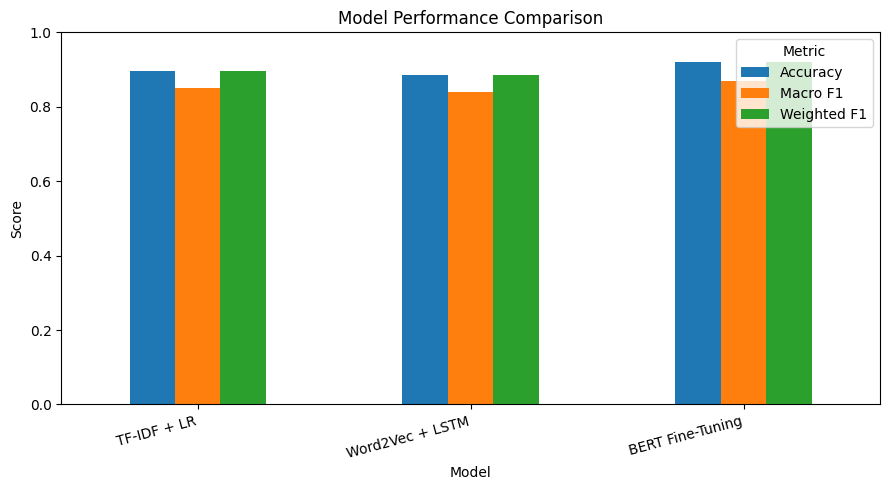

In [95]:
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
ax = results_df.set_index("Model")[metrics].plot(kind="bar", figsize=(9, 5))

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15, ha="right")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

## 5.1  Conclusion & Recommendation

## Conclusion

This project presents a systematic comparison of **three NLP approaches for tweet-based emotion classification**: **TF-IDF + Logistic Regression**, **Word2Vec + LSTM**, and **BERT Fine-Tuning**.  
All models were evaluated using **accuracy**, **macro F1**, and **weighted F1**, allowing analysis of both overall predictive power and robustness under class imbalance.

### Model Comparison and Key Findings

- **TF-IDF + Logistic Regression**
  - Achieved a strong and reliable baseline with **~89.6% accuracy** and **macro F1 ≈ 0.85**.
  - Performed consistently well on majority emotion classes (*sadness*, *joy*, *anger*, *fear*).
  - Minority classes (*love*, *surprise*) showed weaker recall, reflecting the limitation of bag-of-words features in modeling subtle emotional semantics.
  - Confirms that classical linear models remain competitive for short-text classification when paired with clean preprocessing and TF-IDF features.

- **Word2Vec + LSTM**
  - Achieved **~88.4% accuracy** and **macro F1 ≈ 0.84**, narrowing the gap with TF-IDF compared to earlier experiments.
  - Demonstrated clear learning dynamics: slow convergence in early epochs followed by stable improvement after sufficient training.
  - Leveraged **pre-trained Word2Vec embeddings**, enabling better semantic representation than TF-IDF, particularly for context-dependent emotions.
  - Still showed sensitivity to class imbalance and training stability, indicating that sequence-based models require careful tuning and sufficient data to consistently outperform simpler baselines.

- **BERT Fine-Tuning**
  - Delivered the strongest overall results:
    - **Accuracy: ~91.9%**
    - **Macro F1: ~0.87**
    - **Weighted F1: ~0.92**
  - Achieved the most balanced performance across both majority and minority emotion classes.
  - Confusion matrix analysis shows reduced cross-class confusion, especially for semantically similar emotions.
  - Effectively captured contextual and compositional meaning in short, noisy tweet text through pre-trained transformer representations.

### Overall Observations

- A clear performance progression is observed from **TF-IDF → Word2Vec + LSTM → BERT**, though gains from LSTM over TF-IDF are moderate.
- **Pre-trained semantic knowledge** (Word2Vec, BERT) consistently improves generalization compared to purely frequency-based representations.
- Model complexity alone does not guarantee superior performance; training stability, data size, and class imbalance play critical roles.
- **BERT demonstrates the highest robustness** to class imbalance and semantic overlap among emotion categories.

### Final Conclusion

Overall, the experiments confirm that **transformer-based models are the most effective for emotion classification in social media text**.  
While **TF-IDF + Logistic Regression** provides a strong and efficient baseline, and **Word2Vec + LSTM** offers meaningful semantic improvements, **BERT Fine-Tuning consistently achieves the best balance between accuracy and class-level performance**, making it the most suitable model for real-world emotion analysis on tweets.

---

### Recommendation

- Use **BERT Fine-Tuning** as the primary model for deployment.
- For further improvements:
  - Experiment with **domain-specific transformers** (e.g., BERTweet).
  - Apply **class-aware loss functions** to further improve minority-class performance.
  - Incorporate emojis, hashtags, or metadata as auxiliary features.
  - Explore **model distillation** for faster inference.
  - Periodically retrain the model to adapt to evolving social-media language.


# 8. References

- **Dataset Link**: <br>
  https://www.kaggle.com/datasets/parulpandey/emotion-dataset/data 
- **Github**: <br>
  https://github.com/tuanTaAnh/Emotion-Classification